# Statistics

This notebook needs to be executed to create all the plots and tables of statistical tests that are referenced in the main paper.Rmd file. Output is created from the csv files located at ../results/single_run


The initial results can be reproduced by running the shell script <run.zsh>

All results of this notebook are saved in ../docs/rmd/plots and ../docs/rmd/tables

In [1]:
from scipy.stats import mannwhitneyu, normaltest
import pandas as pd
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from typing import Tuple, List
from statistics import mean
from dataclasses import dataclass
import csv
import os

%cd ~/github/intelligent_information_systems_research_project/seminar/src

[Errno 2] No such file or directory: '/Users/rmn/github/intelligent_information_systems_research_project/seminar/src'
/Users/rmn/github/intelligent_information_systems_research_project/src


In [2]:
# plotting setup

%matplotlib inline

FIGSIZE_INCHES =  14, 9
FIGSIZE_INCHES_LARGE =  16, 10
TITLE_FONT_SIZE = 17
TITLE_FONT_SIZE_LARGE = 20


In [3]:
# set output paths

PATH = "../docs/rmd/"
TABLE_PATH = f"{PATH}/tables"
PLOT_PATH =  f"{PATH}/plots"

jobs = (
    'os.makedirs(f"{TABLE_PATH}/csv")',
    'os.makedirs(f"{TABLE_PATH}/md")',
    'os.makedirs(f"{PLOT_PATH}")'
)

for job in jobs:
    try:
        exec(job)
    except FileExistsError:
        pass

# set input paths

DIR_TOURNAMENT = "../results/single_run/e_lexicase"
DIR_ELEXICASE = "../results/single_run/tournament"


tournament_files = os.listdir(DIR_TOURNAMENT)
elexicase_files = os.listdir(DIR_ELEXICASE)

if not len(tournament_files) == len(elexicase_files):
    print("Warning - Unequal number of records!\nVariable <TOTAL_RUNS> not set")
    TOTAL_RUNS = None
    
else:
    TOTAL_RUNS = len(tournament_files)
    print(f"Total number of Runs: {TOTAL_RUNS}")


Total number of Runs: 50


In [4]:
def tsv_to_df(filepath: str) -> pd.DataFrame:
    """Return the results for ../results/single_run/<algorithm><id>.tsv as a pd.DataFrame"""

    df = pd.read_csv(filepath_or_buffer=filepath, sep="\t", index_col=False, skipinitialspace=True)
    
    df.columns = df.columns.str.strip()
    
    rename_dict = {
        "avg" : "mean_training_error",
        "std" : "std_training_error",
        "min" : "min_training_error",
        "max" : "max_training_error",
        "elite_testing_mse" : "testing_error",
        "elite_testing_err_std" : "std_testing_error"
        
    }
        
    return df.rename(columns=rename_dict) 
        


# read and store all log files into dataframes
tournament_logs = []
elexicase_logs = []

for a, b in zip(tournament_files, elexicase_files):
    tournament_logs.append(
        tsv_to_df(f"{DIR_TOURNAMENT}/{a}")
    )
    elexicase_logs.append(
        tsv_to_df(f"{DIR_ELEXICASE}/{b}")
    )
    

# Descriptive Statistics

In [5]:
# print all individual logs

for idx, (a, b) in enumerate(zip(tournament_logs, elexicase_logs)):
    print(f"{idx+1}.th Run:\nTournament-Selection:\n{a}\nE-Lexicase-Selection:\n{b}\n--------------\n")

1.th Run:
Tournament-Selection:
     gen  nevals  mean_training_error  std_training_error  min_training_error  \
0      0     500         1.877380e+13        4.192760e+14           104.23400   
1      1     405         4.368900e+06        8.380810e+07            25.32210   
2      2     414         1.841330e+08        3.474490e+09            18.93650   
3      3     427         4.024750e+05        4.979260e+06            18.93650   
4      4     406         1.379940e+05        9.994610e+05            18.93650   
..   ...     ...                  ...                 ...                 ...   
96    96     414         7.629160e+01        7.116270e+02             3.86481   
97    97     428         5.604940e+04        7.242480e+05             3.88782   
98    98     423         1.130200e+04        1.654270e+05             3.74296   
99    99     422         8.970610e+03        1.708850e+05             3.74296   
100  100     442         2.411490e+04        3.924840e+05             3.74138

In [6]:
def to_master_record(dfs: List[pd.DataFrame]) -> pd.DataFrame:
    
    """
    Summarize and return the results from each individual dataframe into a master record
    """
    
    headers = dfs[0].columns.values.tolist()
    ngens = len(dfs[0]["gen"])
    
    master = pd.DataFrame(0, index=np.arange(ngens), columns=headers)
    
    def mean_stddev(std_devs: List[float]) -> float:
        """returns the mean for a list of std_deviations """
        agg = 0.0
        for std_dev in std_devs:
            agg += std_dev ** 2
        return sqrt(agg / len(std_devs))
    
    for header in headers:
                
        for gen in range(ngens):
            
            vals = []
            
            for df in dfs:
                vals.append(
                    float(df[header].iloc[gen])
                )

            if not "std" in header:
                master.loc[gen,header] = mean(vals)
            
            else:
                master.loc[gen,header] = mean_stddev(vals)
                
    return master



master_tournmament = to_master_record(tournament_logs)
master_elexicase = to_master_record(elexicase_logs)
    

In [7]:
master_tournmament.to_csv(path_or_buf=f"{TABLE_PATH}/csv/master_tournament.csv")
master_tournmament.to_markdown(buf=f"{TABLE_PATH}/md/master_tournament.md")

master_tournmament

,gen,nevals,mean_training_error,std_training_error,min_training_error,max_training_error,testing_error,std_testing_error,avg_size,elite_size
0,0,500.00,7.596361e+11,8.458906e+13,77.242718,3.796506e+14,NaN,NaN,NaN,NaN
1,1,418.36,6.043342e+09,8.405707e+11,60.512964,2.973801e+12,62.693290,95.281668,3.33072,4.34
2,2,419.24,9.656059e+10,1.208278e+13,58.283258,4.825372e+13,59.737638,86.052233,3.75304,4.74
3,3,419.32,8.701397e+09,8.822183e+11,51.398498,4.048817e+12,52.715832,82.091599,4.06832,5.60
4,4,419.02,2.953157e+13,4.629599e+15,44.591850,1.476569e+16,46.310680,69.567978,4.50024,5.98
...,...,...,...,...,...,...,...,...,...,...
96,96,419.64,4.627784e+10,6.137275e+12,7.349396,2.286823e+13,8.169067,16.682458,106.52604,113.70
97,97,420.70,1.229285e+12,1.941560e+14,7.279273,6.146411e+14,8.093299,16.595818,108.09064,115.16
98,98,417.70,6.830040e+10,9.527246e+12,7.195512,3.414325e+13,8.056461,16.560341,109.08952,115.34
99,99,420.78,6.317027e+11,9.174773e+13,7.108866,3.158481e+14,7.933976,16.614500,109.76100,114.24


In [8]:
master_tournmament.describe().to_csv(path_or_buf=f"{TABLE_PATH}/csv/master_tournament_descriptive.csv")
master_tournmament.describe().to_markdown(buf=f"{TABLE_PATH}/md/master_tournament_descriptive.md")

master_tournmament.describe()

,gen,nevals,mean_training_error,std_training_error,min_training_error,max_training_error,testing_error,std_testing_error,avg_size,elite_size
count,101.000000,101.000000,1.010000e+02,1.010000e+02,101.000000,1.010000e+02,100.000000,100.000000,100.000000,100.000000
mean,50.000000,420.741980,2.092614e+18,3.305357e+20,16.482771,1.046309e+21,16.904957,28.857978,55.674388,62.069600
std,29.300171,8.114939,2.098028e+19,3.313954e+21,12.514352,1.049016e+22,11.116562,15.731527,34.503924,36.849732
min,0.000000,417.300000,2.582030e+08,1.463390e+10,7.066208,1.193720e+11,7.847309,16.217493,3.330720,4.340000
25%,25.000000,418.780000,2.151894e+10,3.044239e+12,8.479094,1.070232e+13,9.350339,18.343617,25.132730,28.195000
50%,50.000000,420.000000,3.494635e+11,5.511534e+13,11.918314,1.747285e+14,12.874061,22.714682,57.299120,66.400000
75%,75.000000,421.000000,4.892936e+12,6.455802e+14,18.773264,2.238973e+15,19.685216,32.749963,87.851720,96.625000
max,100.000000,500.000000,2.108540e+20,3.330558e+22,77.242718,1.054272e+23,62.693290,95.281668,109.761000,115.340000


In [9]:
master_elexicase.to_csv(path_or_buf=f"{TABLE_PATH}/csv/master_elexicase.csv")
master_elexicase.to_markdown(buf=f"{TABLE_PATH}/md/master_elexicase.md")

master_elexicase

,gen,nevals,mean_training_error,std_training_error,min_training_error,max_training_error,testing_error,std_testing_error,avg_size,elite_size
0,0,500.00,4.852074e+12,7.593860e+14,74.202538,2.425866e+15,NaN,NaN,NaN,NaN
1,1,419.02,2.821616e+12,4.451762e+14,74.622220,1.410654e+15,77.518454,110.243627,3.21936,4.28
2,2,419.64,2.975103e+10,4.597396e+12,70.311520,1.487234e+13,70.187260,105.154213,3.36396,4.32
3,3,418.18,4.539209e+12,7.162387e+14,64.218302,2.269605e+15,65.041406,94.178488,3.54108,4.64
4,4,418.96,1.975877e+12,2.236630e+14,55.840478,9.587264e+14,56.538078,81.668696,3.68316,4.86
...,...,...,...,...,...,...,...,...,...,...
96,96,420.00,4.027489e+07,3.112777e+09,9.905963,1.892610e+10,11.348329,48.978851,108.44072,110.04
97,97,419.88,1.458118e+09,2.230980e+11,9.809928,7.287825e+11,11.362122,50.622184,108.41060,111.30
98,98,418.32,2.698470e+09,4.104083e+11,9.775260,1.312088e+12,11.279313,51.063372,108.08492,109.68
99,99,419.38,1.314499e+08,1.126143e+10,9.709948,4.995217e+10,11.232865,51.078360,108.12644,110.84


In [10]:
master_elexicase.describe().to_csv(path_or_buf=f"{TABLE_PATH}/csv/master_elexicase_descriptive.csv")
master_elexicase.describe().to_markdown(buf=f"{TABLE_PATH}/md/master_elexicase_descriptive.md")

master_elexicase.describe()

,gen,nevals,mean_training_error,std_training_error,min_training_error,max_training_error,testing_error,std_testing_error,avg_size,elite_size
count,101.000000,101.000000,1.010000e+02,1.010000e+02,101.000000,1.010000e+02,100.000000,100.000000,100.000000,100.00000
mean,50.000000,420.780594,7.533781e+12,1.186094e+15,22.013381,3.762638e+15,22.456320,39.048426,58.416072,63.81920
std,29.300171,8.109191,5.900311e+13,9.313627e+15,16.670182,2.950203e+16,15.904289,19.225375,34.514682,36.35606
min,0.000000,416.240000,4.660413e+05,3.314323e+07,9.680207,1.539125e+08,11.128606,21.487383,3.219360,4.28000
25%,25.000000,418.900000,2.528193e+08,2.727451e+10,11.315864,1.192373e+11,12.088987,24.860050,28.232970,29.61500
50%,50.000000,420.040000,2.196352e+09,2.647194e+11,14.478467,1.098068e+12,15.223226,30.057368,64.688800,71.44000
75%,75.000000,421.020000,2.027020e+11,3.198174e+13,23.511418,1.012976e+14,23.304690,51.081215,87.394160,94.91000
max,100.000000,500.000000,5.788911e+14,9.137151e+16,74.622220,2.894465e+17,77.518454,110.243627,108.785280,115.66000


In [11]:
def aggregate_cells(dfs: List[pd.DataFrame], header, row) -> List[float]:
    
    vals = []

    for df in dfs:
        
        vals.append(
            df[header].iloc[row]
        )
    
    return vals

LAST_ROW = len(tournament_logs[0]) - 1

# aggregate training errors for elite models in last generation
tournament_elite_training_errors = aggregate_cells(tournament_logs, "min_training_error", LAST_ROW)
elexicase_elite_training_errors = aggregate_cells(elexicase_logs, "min_training_error", LAST_ROW)

# aggregate elite model performance on testing data
tournament_elite_testing_errors = aggregate_cells(tournament_logs, "testing_error", LAST_ROW)
elexicase_elite_testing_errors = aggregate_cells(elexicase_logs, "testing_error", LAST_ROW)


# aggregate size values

tournament_elite_size = aggregate_cells(tournament_logs, "elite_size", LAST_ROW)
elexicase_elite_size = aggregate_cells(elexicase_logs, "elite_size", LAST_ROW)

# aggregate elite model performance on testing data
tournament_avg_size = aggregate_cells(tournament_logs, "avg_size", LAST_ROW)
elexicase_avg_size = aggregate_cells(elexicase_logs, "avg_size", LAST_ROW)


In [12]:
# test if samples are normal distributed at alpha=5%, results are written to ../docs/rmd/tables/normal_dist_test.csv"

def is_normal_distr(vals: List[float], name: str, alpha:float=0.05) -> str:  
    """
    Null Hypothesis: Sample comes from a normal distribution, 
    returns results as csv string:
        <sample,statistic,p-value,alpha,normal_distributed>
    
    """
    statistic, pval = normaltest(vals)
    return f"{name},{statistic},{pval},{alpha},{pval >= alpha}\n"
    

csv_str = (
    "sample,statistic,p-value,alpha,normal_distributed\n" +
    is_normal_distr(tournament_elite_training_errors, "Tournament - Training Errors") +
    is_normal_distr(elexicase_elite_training_errors, "E-Lexicase - Training Errors") +
    is_normal_distr(tournament_elite_testing_errors, "Tournament - Testing Errors") +
    is_normal_distr(elexicase_elite_testing_errors, "E-Lexicase - Testing Errors")
)

print(csv_str)

        
with open(f"../docs/rmd/tables/csv/normal_dist_test.csv", "w") as fstr:
    fstr.write(csv_str)
    

sample,statistic,p-value,alpha,normal_distributed
Tournament - Training Errors,36.146158097642264,1.4156682698650698e-08,0.05,False
E-Lexicase - Training Errors,1.5752583485637548,0.4549220586923548,0.05,True
Tournament - Testing Errors,32.50325251582114,8.750006874635094e-08,0.05,False
E-Lexicase - Testing Errors,59.135132021691895,1.4420132076469131e-13,0.05,False



In [13]:
def test_mannwhitneyu(sample_a: List[float], sample_b: List[float], alpha:float=0.05) -> Tuple[float,float]:
    """
    performs a mann whitney u ranksum test for sample_a and sample_b, 
    returns the results as csv string
        <test statistic and p-value>
    """
    statistic, pval = mannwhitneyu(x = sample_a,y = sample_b)
    print(f"Statistic: {statistic}\nPVal: {pval}\nPVal < ALPHA: {pval < alpha}")

    if pval > alpha:
        print(f"Results supports H0 for alpha={alpha}\n H0: The distribution underlying sample_a is the same as the distribution underlying sample_b")

    else:
        print(f"H0 can be rejected for alpha={alpha}\nThe distribution underlying sample_a is NOT the same as the distribution underlying sample_b")
    
    return statistic, pval


@dataclass
class Sample:
    vals: List[float]
    name: str

        
def mark(pval:float) -> str:
        """
        mark pvalues for statistical significance:
            alpha:
                0.1   : *
                0.05  : **
                0.025 : ***
        """
        s = str(pval)
        
        if pval < 0.1:
            s += '*'
        if pval < 0.05:
            s += '*'
        if pval < 0.025:
            s += '*'
            
        return s        


def mwu_csv_matrix(
    samples: List[Sample],
    alpha:float=0.05
) -> str:
    """
    returns the results of mwu test as a csv matrix

    """
    
    # x 0 1 2 3
    # 0
    # 1
    # 2
    # 3
    
    
    names = []
    
    for sample in samples:
        names.append(sample.name)
    
    matrix = [[None for _ in range(len(samples))] for _ in range(len(samples))]
    
    for ix, xsample in enumerate(samples):
        for iy, ysample in enumerate(samples):
            _, p = mannwhitneyu(x=xsample.vals, y=ysample.vals)
            matrix[ix][iy] = p
            
    csv_str = "{0},{1},{2},{3}\n".format(*[name for name in names])
    
    for row,name in zip(matrix, names):
        csv_str += "{},{},{},{},{}\n".format(name, *row)
        
    return csv_str


In [14]:
# MWU - Error

samples = [
    Sample(tournament_elite_training_errors, "tournament_training_errors"),
    Sample(tournament_elite_testing_errors, "tournament_testing_errors"),
    Sample(elexicase_elite_training_errors, "elexicase_training_errors"),
    Sample(elexicase_elite_testing_errors, "elexicase_testing_errors") 
]


csv = mwu_csv_matrix(samples)

with open("../docs/rmd/tables/csv/mwu_matrix_error.csv", "w") as f:
    f.write(csv)



pd.read_csv(open("../docs/rmd/tables/csv/mwu_matrix_error.csv"))


,tournament_training_errors,tournament_testing_errors,elexicase_training_errors,elexicase_testing_errors
tournament_training_errors,1.000000,0.309230,0.000118,0.000004
tournament_testing_errors,0.309230,1.000000,0.002447,0.000121
elexicase_training_errors,0.000118,0.002447,1.000000,0.256781
elexicase_testing_errors,0.000004,0.000121,0.256781,1.000000


In [15]:
# MWU - Size

# MWU - Error

samples_size = [
    Sample(tournament_elite_size, "tournament_elite_size"),
    Sample(elexicase_elite_size, "elexicase_elite_size"),
    Sample(tournament_avg_size, "tournament_avg_size"),
    Sample(elexicase_avg_size, "elexicase_avg_size") 
]


csv = mwu_csv_matrix(samples_size)

with open("../docs/rmd/tables/csv/mwu_matrix_size.csv", "w") as f:
    f.write(csv)



pd.read_csv(open("../docs/rmd/tables/csv/mwu_matrix_size.csv"))

,tournament_elite_size,elexicase_elite_size,tournament_avg_size,elexicase_avg_size
tournament_elite_size,1.000000,0.857733,0.532686,0.651586
elexicase_elite_size,0.857733,1.000000,0.764262,0.681665
tournament_avg_size,0.532686,0.764262,1.000000,0.991749
elexicase_avg_size,0.651586,0.681665,0.991749,1.000000


In [16]:
def save_as_boxplots(
    sample_a: List[float],
    sample_b: List[float],
    title: str,
    a_label:str, b_label: str, filename: str) -> None:

    PATH = f"../docs/rmd/plots/{filename}.png"

    fig, ax = plt.subplots()
    fig.set_size_inches(*FIGSIZE_INCHES)
    
    plt.grid(visible=True, axis='both')

    ax.boxplot(
        x = [sample_a, sample_b],
        labels=[a_label, b_label]
    )

    ax.set_title(title, fontsize=TITLE_FONT_SIZE_LARGE)
    ax.set_ylabel("MSE")
    plt.savefig(PATH)
    plt.show()
    
def save_as_boxplots_all(
    sample_a: List[float],
    sample_b: List[float],
    sample_c: List[float],
    sample_d: List[float],
    title: str,
    a_label:str, b_label: str, c_label:str,d_label: str,
    filename: str
) -> None:

    PATH = f"../docs/rmd/plots/{filename}.png"

    fig, ax = plt.subplots()
    fig.set_size_inches(*FIGSIZE_INCHES_LARGE)
    
    plt.grid(visible=True, axis='both')

    ax.boxplot(
        x = [sample_a, sample_b, sample_c, sample_d],
        labels=[a_label, b_label, c_label, d_label]
    )
    
    ax.set_title(title, fontsize=TITLE_FONT_SIZE_LARGE)
    ax.set_ylabel("MSE")
    plt.savefig(PATH)
    plt.show()



Statistic: 691.0
PVal: 0.00011802218213049289
PVal < ALPHA: True
H0 can be rejected for alpha=0.05
The distribution underlying sample_a is NOT the same as the distribution underlying sample_b


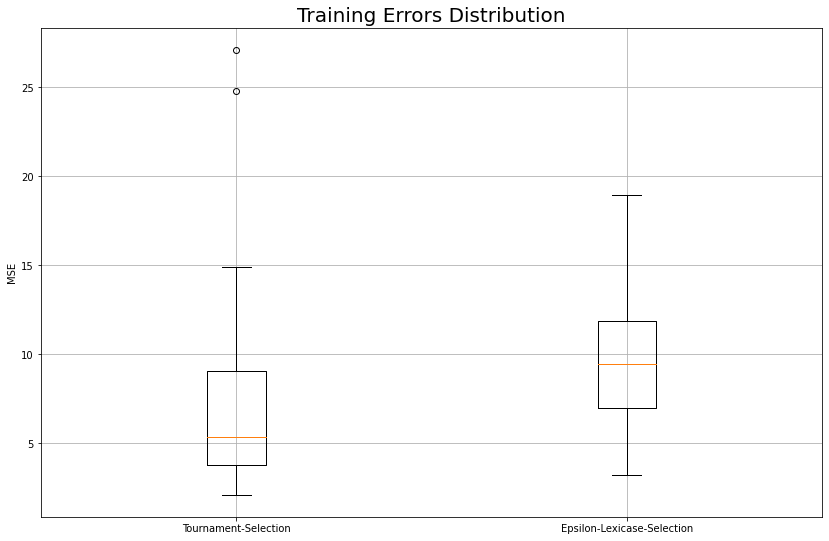

In [17]:
test_mannwhitneyu(tournament_elite_training_errors, elexicase_elite_training_errors)

save_as_boxplots(
    tournament_elite_training_errors,
    elexicase_elite_training_errors,
    "Training Errors Distribution",
    "Tournament-Selection",
    "Epsilon-Lexicase-Selection",
    "mean_training_errors_boxplot"
)

Statistic: 692.0
PVal: 0.00012138866342650596
PVal < ALPHA: True
H0 can be rejected for alpha=0.05
The distribution underlying sample_a is NOT the same as the distribution underlying sample_b


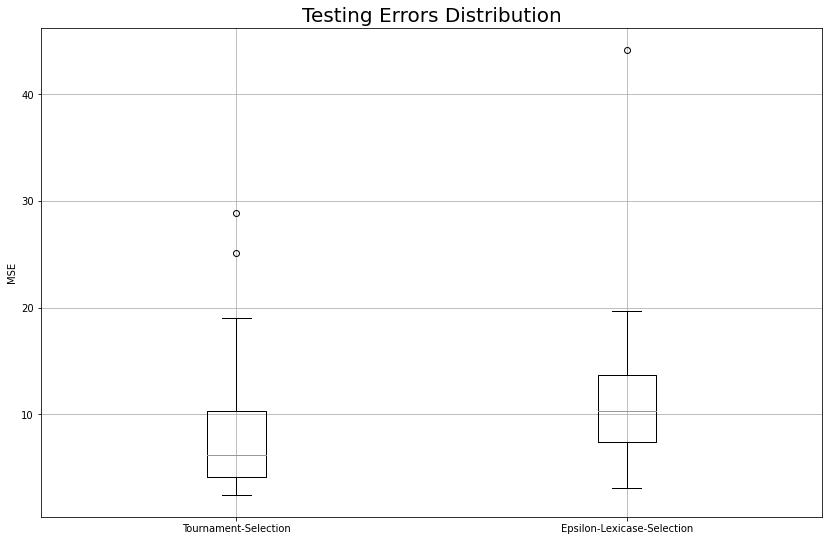

In [18]:
test_mannwhitneyu(tournament_elite_testing_errors, elexicase_elite_testing_errors)

save_as_boxplots(
    tournament_elite_testing_errors,
    elexicase_elite_testing_errors,
    "Testing Errors Distribution",
    "Tournament-Selection",
    "Epsilon-Lexicase-Selection",
    "mean_testing_errors_boxplot"
)

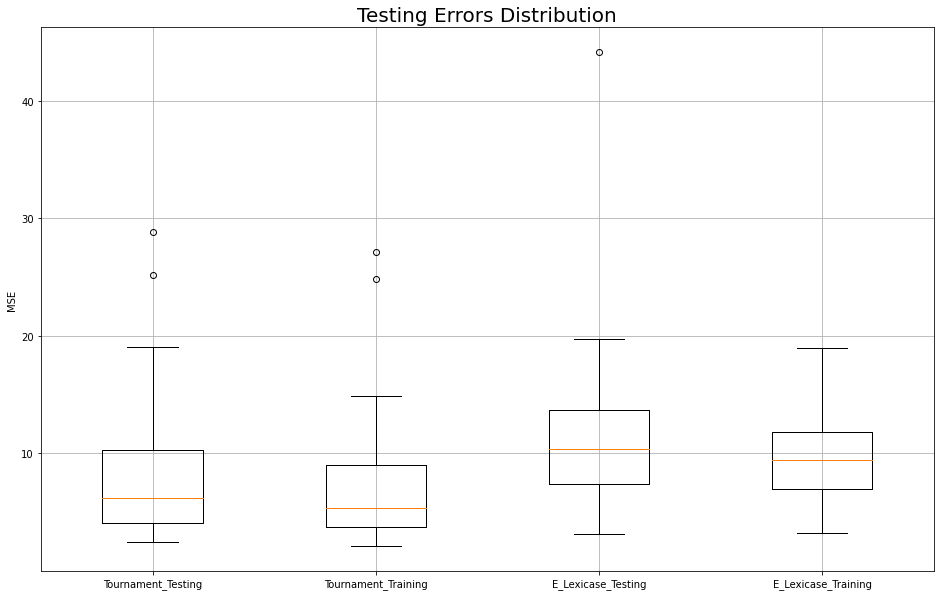

In [27]:
save_as_boxplots_all(
    sample_a=tournament_elite_testing_errors,
    sample_b=tournament_elite_training_errors,
    sample_c=elexicase_elite_testing_errors,
    sample_d=elexicase_elite_training_errors,
    title="Testing Errors Distribution",
    a_label="Tournament_Testing",
    b_label="Tournament_Training",
    c_label="E_Lexicase_Testing",
    d_label="E_Lexicase_Training",
    filename="mean_error_boxplot_all"
)

In [20]:
# testing error gap

def evolutionary_plot(
    master_record: pd.DataFrame, 
    header_1: str, 
    header_2: str, 
    algorithm_name: str, 
    filename: str, 
    suptitle: str,
    y_scale: Tuple[int, int]=(0,100)
):
    
    
    PATH = f"../docs/rmd/plots/{filename}.png"
    
    X = np.arange(
        min(master_record["gen"]),
        max(master_record["gen"] +1)
    )
    
    fig, ax = plt.subplots()
    fig.set_size_inches(*FIGSIZE_INCHES)
    
    
    ax.plot(X, master_record[header_1], label=header_1)
    ax.plot(X, master_record[header_2], label=header_2)
    
    ax.set_title(f"{suptitle} - {algorithm_name}", fontsize=TITLE_FONT_SIZE_LARGE)
    ax.set_ylim(*y_scale)
    
    ax.set_xlabel("generations")
    ax.set_ylabel("MSE")
    ax.legend()
    
    plt.grid(visible=True, axis='both')
    plt.savefig(PATH)
    plt.show()
    
    
# testing error gap

def evolutionary_masterplot(
    master_record_1: pd.DataFrame,
    master_record_2: pd.DataFrame,
    total_runs: int,
    header_1: str,
    header_2: str,
    algorithm_1_name: str,
    algorithm_2_name: str,
    filename: str,
    suptitle: str,
    y_label: str,
    y_scale: Tuple[int, int]=(0,100),
):
    
    
    PATH = f"../docs/rmd/plots/{filename}.png"
    
    X = np.arange(
        min(master_record_1["gen"]),
        max(master_record_2["gen"] +1)
    )
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(*FIGSIZE_INCHES_LARGE)
    
    
    ax1.plot(X, master_record_1[header_1], label=header_1)
    ax1.plot(X, master_record_1[header_2], label=header_2)
    ax1.grid(True)
    
    ax2.plot(X, master_record_2[header_1], label=header_1)
    ax2.plot(X, master_record_2[header_2], label=header_2)
    ax2.grid(True)
    
    ax1.set_title(algorithm_1_name, fontsize=TITLE_FONT_SIZE)
    ax2.set_title(algorithm_2_name, fontsize=TITLE_FONT_SIZE)
    
    ax1.set_ylim(*y_scale)
    ax2.set_ylim(*y_scale)
    
    ax1.set_xlabel("generations")
    ax1.set_ylabel(y_label)
    
    ax2.set_xlabel("generations")
    ax2.set_ylabel("MSE")
    
    ax1.legend()
    ax2.legend()
    
    plt.suptitle(f"{suptitle} for {total_runs} total Runs", fontsize=TITLE_FONT_SIZE_LARGE)
    
    plt.savefig(PATH)
    plt.show()
    
    
# testing error gap

def evolutionary_combined_masterplot(
    master_record_1: pd.DataFrame,
    master_record_2: pd.DataFrame,
    total_runs: int,
    header_1: str,
    header_2: str,
    algorithm_1_name: str,
    algorithm_2_name: str,
    filename: str,
    suptitle: str,
    y_label: str,
    y_scale: Tuple[int, int]=(0,100),
):
    
    
    PATH = f"../docs/rmd/plots/{filename}.png"
    
    X = np.arange(
        min(master_record_1["gen"]),
        max(master_record_2["gen"] +1)
    )
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(*FIGSIZE_INCHES_LARGE)
    
    
    ax.plot(X, master_record_1[header_1], "b" , label=f"{algorithm_1_name}_{header_1}")
    ax.plot(X, master_record_1[header_2], "g" , label=f"{algorithm_1_name}_{header_2}")
    ax.plot(X, master_record_2[header_1], "y", label=f"{algorithm_2_name}_{header_1}")
    ax.plot(X, master_record_2[header_2], "r",label=f"{algorithm_2_name}_{header_2}")
    
    ax.grid(True)

    
    ax.set_ylim(*y_scale)
    ax.set_ylim(*y_scale)
    
    ax.set_ymargin(1.5)
    
    ax.set_xlabel("generations")
    ax.set_ylabel(y_label)

    ax.legend()
    
    plt.suptitle(f"{suptitle} for {total_runs} total Runs", fontsize=TITLE_FONT_SIZE)
    
    plt.savefig(PATH)
    plt.show()
    
    

# Mean Error - Plots

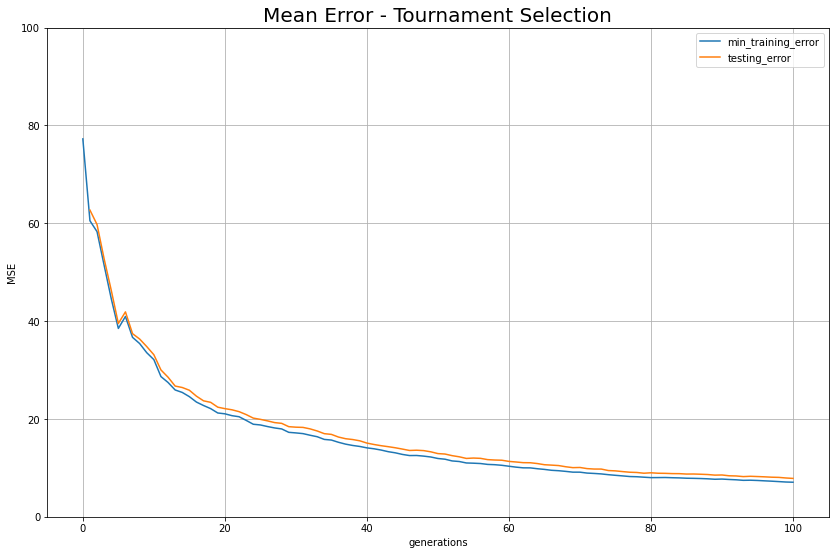

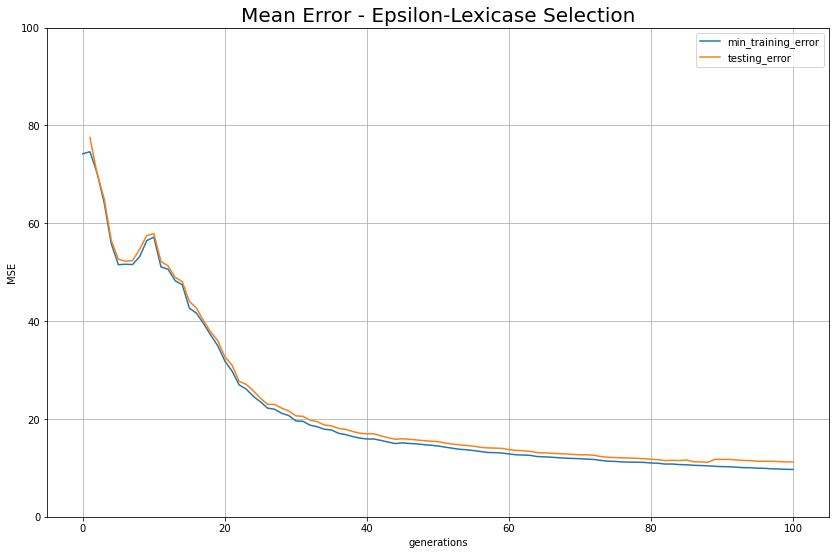

In [21]:
evolutionary_plot(
    master_record=master_tournmament,
    header_1="min_training_error",
    header_2="testing_error",
    algorithm_name="Tournament Selection",
    filename="tournament_evolution",
    suptitle="Mean Error"
)
evolutionary_plot(
    master_record=master_elexicase,
    header_1="min_training_error",
    header_2="testing_error",
    algorithm_name="Epsilon-Lexicase Selection",
    filename="elexicase_evolution",
    suptitle="Mean Error"
)

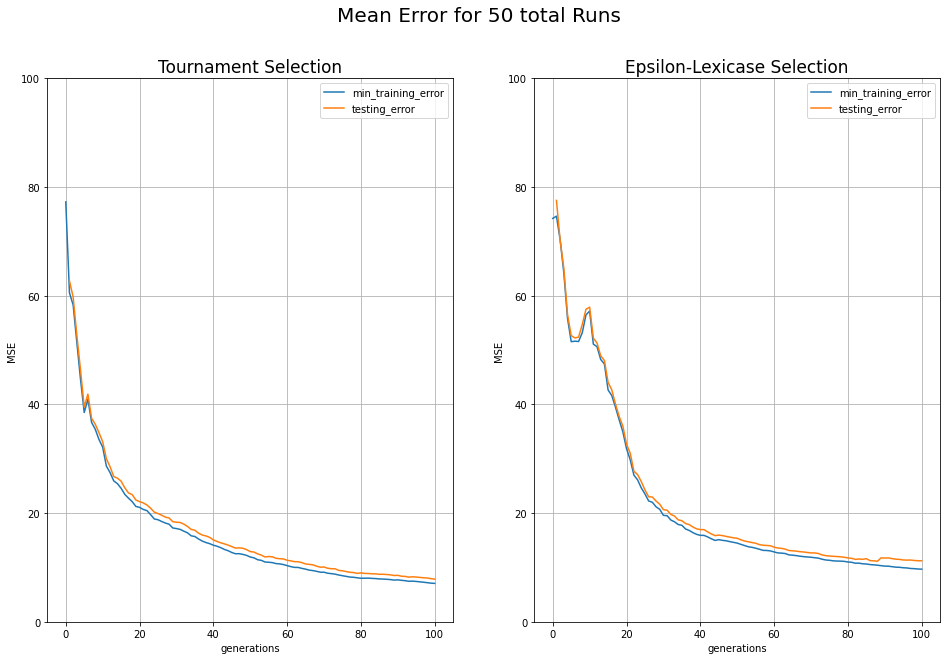

In [22]:
evolutionary_masterplot(
    master_record_1=master_tournmament,
    master_record_2=master_elexicase,
    total_runs=TOTAL_RUNS,
    header_1="min_training_error",
    header_2="testing_error",
    algorithm_1_name="Tournament Selection",
    algorithm_2_name="Epsilon-Lexicase Selection",
    filename="mean_error_subplotted",
    suptitle="Mean Error",
    y_label="MSE"
)

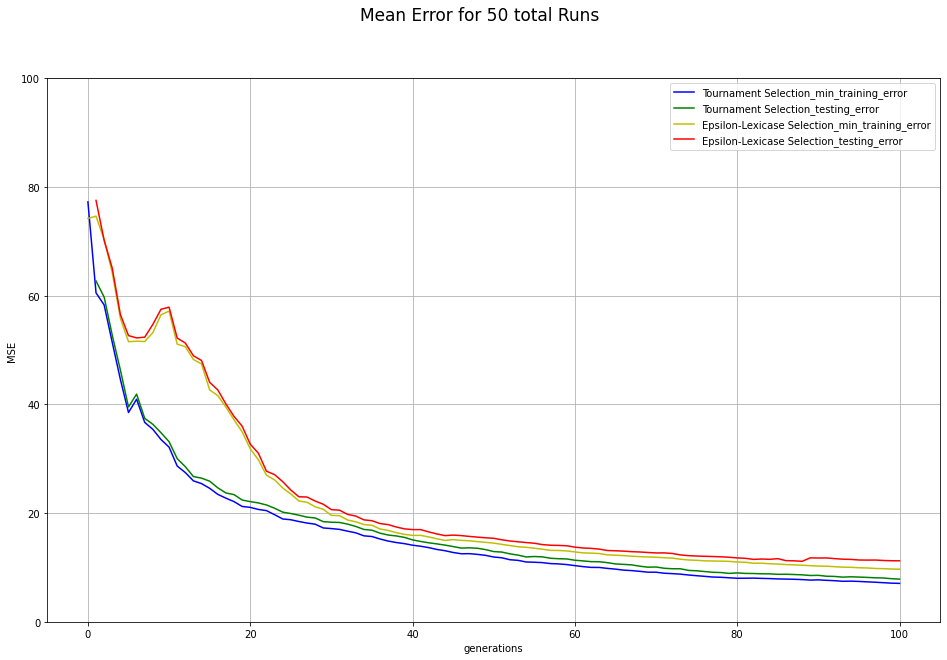

In [23]:
    
evolutionary_combined_masterplot(
    master_record_1=master_tournmament,
    master_record_2=master_elexicase,
    total_runs=TOTAL_RUNS,
    header_1="min_training_error",
    header_2="testing_error",
    algorithm_1_name="Tournament Selection",
    algorithm_2_name="Epsilon-Lexicase Selection",
    filename="mean_error_combined",
    suptitle="Mean Error",
    y_label="MSE"
)

# Mean Size Plots

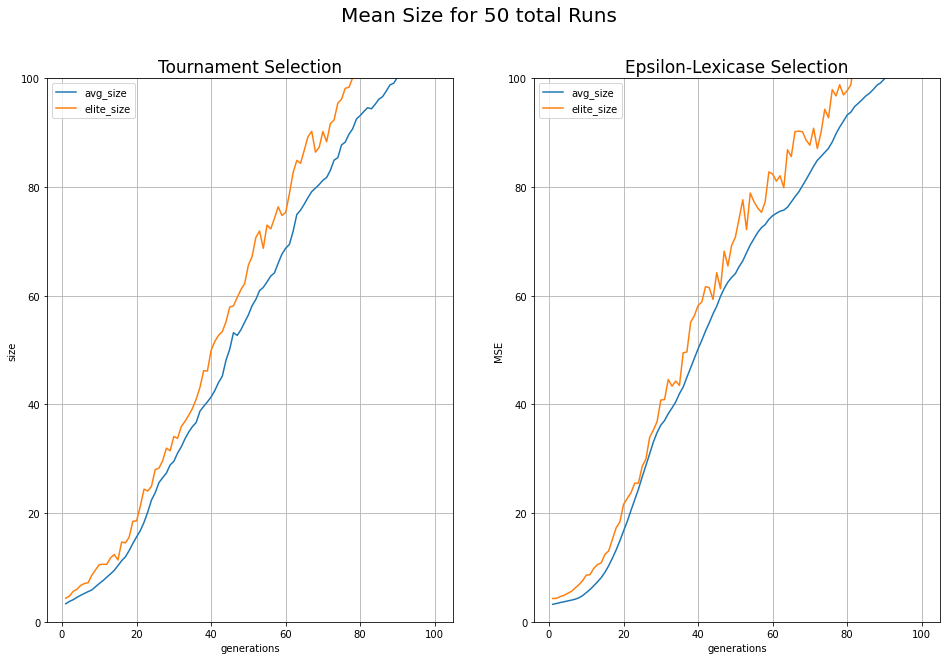

In [24]:
evolutionary_masterplot(
    master_record_1=master_tournmament,
    master_record_2=master_elexicase,
    total_runs=TOTAL_RUNS,
    header_1="avg_size",
    header_2="elite_size",
    algorithm_1_name="Tournament Selection",
    algorithm_2_name="Epsilon-Lexicase Selection",
    filename="size_subplotted",
    suptitle="Mean Size",
    y_label="size"
)

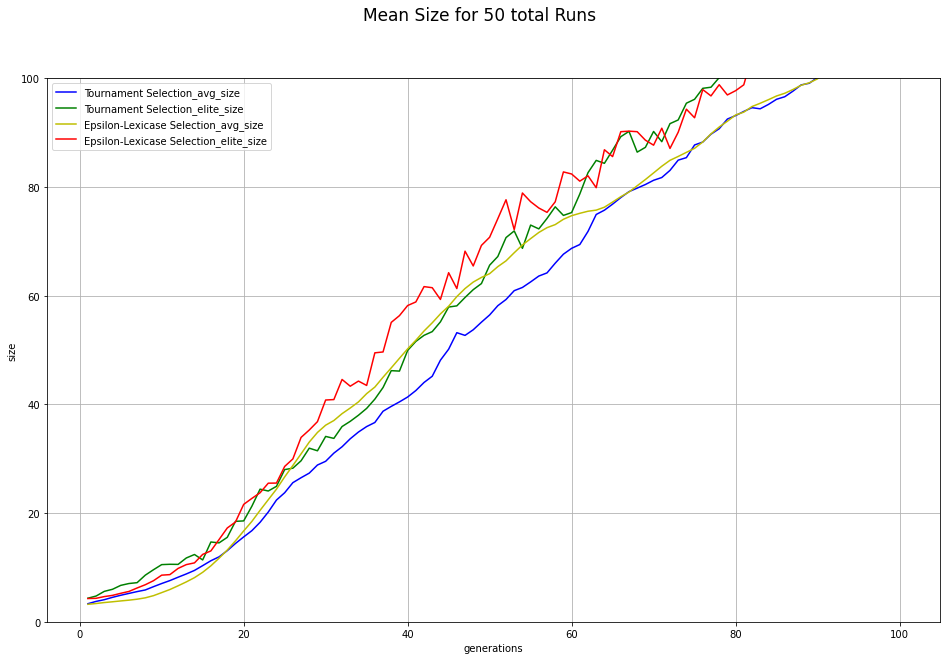

In [25]:
evolutionary_combined_masterplot(
    master_record_1=master_tournmament,
    master_record_2=master_elexicase,
    total_runs=TOTAL_RUNS,
    header_1="avg_size",
    header_2="elite_size",
    algorithm_1_name="Tournament Selection",
    algorithm_2_name="Epsilon-Lexicase Selection",
    filename="size_combined",
    suptitle="Mean Size",
    y_label="size"
)

In [26]:
# add, commit and push to github remote repo
# ! git add * && git commit -m "working in jupyter notebook" && git push